In [ ]:
import numpy as np
from scipy.integrate import quad, dblquad
from functools import lru_cache
import matplotlib.pyplot as plt
import pandas as pd

# --- Physical constants ---
I0 = 1
eps0 = 8.854e-12
r = 1
c = 3e8
mu0 = 4 * np.pi * 1e-7
Z = 376.730


# --- S_theta(θ, λ, L, ψ) ---
def S_theta(theta, lam, L, psi):
    def inner_integrand(t):
        numerator = np.cos((2 * np.pi / lam) * L / 2 * np.cos(theta + t)) - np.cos((2 * np.pi / lam) * L / 2)
        denominator = np.sin(theta + t)
        return numerator / denominator

    inner, _ = quad(inner_integrand, -psi / 2, psi / 2, limit=200)
    E_theta = 1j * Z * I0 * np.exp(-1j * (2 * np.pi / lam) * r) / (2 * np.pi * r) * (inner / psi)
    H_phi = E_theta / Z
    return np.real(E_theta * np.conj(H_phi))


# --- Ptot(ψ, λ, L) ---
def Ptot(psi, lam, L):
    def integrand(theta):
        return S_theta(theta, lam, L, psi) * r**2 * np.sin(theta)
    result, _ = quad(integrand, 0, np.pi, limit=200)
    return 2 * np.pi * result


# --- L(r, l) ---
def Lfunc(r, l):
    return (mu0 * l) / (2 * np.pi) * (np.log(2 * l / r) - 1)


# --- Cache heavy M(θ, l) evaluations ---
@lru_cache(maxsize=None)
def Mfunc(theta, l):
    def integrand(r2, r1):
        denom = np.sqrt(r1**2 + r2**2 - 2 * r1 * r2 * np.cos(theta))
        return np.cos(theta) / denom

    val, _ = dblquad(integrand, 0, l, lambda _: 0, lambda _: l)
    return (mu0 / (4 * np.pi)) * val


# --- Leff(α, l, nmax) ---
@lru_cache(maxsize=None)
def Leff(alpha, l, nmax=20):
    n = nmax
    term1 = (1 / n) * Lfunc(l * alpha / n, l)
    term2 = (2 / n**2) * sum(
        Mfunc((j - i) * alpha / n, l) for i in range(1, n) for j in range(i + 1, n + 1)
    )
    return term1 + term2


# --- Zant(α, l, λ, nmax) ---
def Zant(alpha, l, lam, nmax=20):
    return Ptot(alpha, lam, l) + 1j * 2 * np.pi * c / lam * Leff(alpha, l, nmax)


# --- Vectorized S11(α, l, λ, Z0, nmax) ---
def S11(alpha, l, lam_array, Z0, nmax=20):
    # Use np.vectorize to handle array inputs efficiently
    @np.vectorize
    def _s11(lam):
        Zant_val = Zant(alpha, l, lam, nmax)
        return np.abs((Zant_val - Z0) / (Zant_val + Z0))
    return _s11(lam_array)



In [34]:
# --- Sweep frequencies ---
freq_vals = np.arange(100e9, 10e12 + 1, 10e9)  # Hz
lambda_vals = c / freq_vals

def append_s11_data(df, angles, lengths, Z0=50, nmax=20):
    records = []
    for angle in angles:
        for length in lengths:
            # Compute S11 over all frequencies
            S11_vals = S11(angle, length, lambda_vals, Z0, nmax)

            # Compute Zant efficiently for each λ using vectorization
            Zant_func = np.vectorize(lambda lam: Zant(angle, length, lam, nmax))
            Zant_vals = Zant_func(lambda_vals)
            Zant_re, Zant_im = np.real(Zant_vals), np.imag(Zant_vals)

            # Combine into records
            for f, sval, zre, zim in zip(freq_vals, S11_vals, Zant_re, Zant_im):
                records.append({
                    "angle": angle,
                    "length": length,
                    "frequency": f,
                    "S11": sval,
                    "Re(Z_ant)": zre,
                    "Im(Z_ant)": zim
                })

    return pd.concat([df, pd.DataFrame.from_records(records)], ignore_index=True)

df = pd.DataFrame(columns=["angle", "length", "frequency", "S11"])

/var/folders/n5/23ytv79x1g1fl8095h273pzw0000gn/T/ipykernel_26687/3067604502.py:21: RuntimeWarning: invalid value encountered in scalar divide
  return numerator / denominator
/var/folders/n5/23ytv79x1g1fl8095h273pzw0000gn/T/ipykernel_26687/3067604502.py:23: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  inner, _ = quad(inner_integrand, -psi / 2, psi / 2, limit=200)
/var/folders/n5/23ytv79x1g1fl8095h273pzw0000gn/T/ipykernel_26687/3067604502.py:33: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, _ = quad(integrand, 0, np.pi, limit=200)
/Users/zachgillis/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2412: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


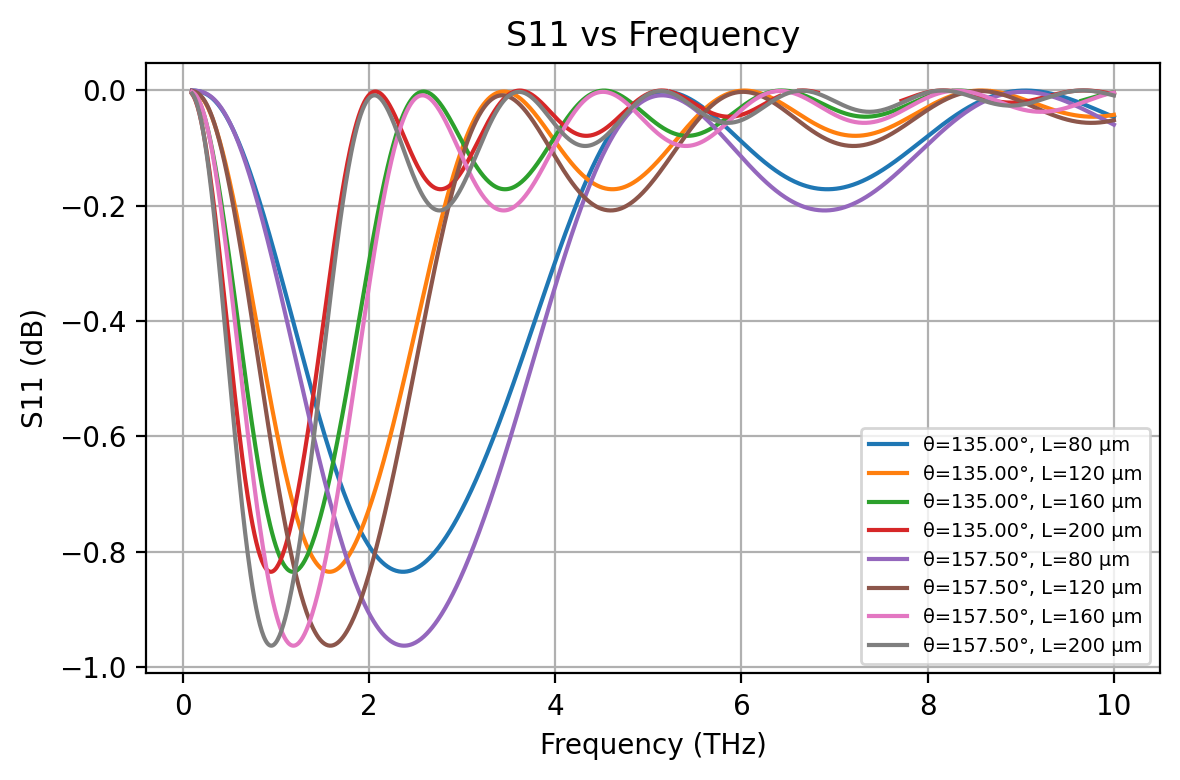

In [35]:
angles = [7*np.pi/8, 3*np.pi/4]
lengths = [80e-6, 120e-6, 160e-6, 200e-6]
df = append_s11_data(df, angles, lengths)

plt.figure(figsize=(6, 4), dpi=200)

for (angle, length), subset in df.groupby(["angle", "length"]):
    label = f"θ={(angle*180/np.pi):.2f}°, L={length*1e6:.0f} µm"
    S11_dB = 20 * np.log10(subset["S11"])
    plt.plot(subset["frequency"]/1e12, S11_dB, label=label)

plt.title("S11 vs Frequency")
plt.xlabel("Frequency (THz)")
plt.ylabel("S11 (dB)")
plt.legend(fontsize=7)
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
df

,angle,length,frequency,S11,Re(Z_ant),Im(Z_ant)
0,2.748894,0.00008,1.000000e+11,0.999981,0.000501,9.633834
1,2.748894,0.00008,1.100000e+11,0.999972,0.000733,10.597217
2,2.748894,0.00008,1.200000e+11,0.999961,0.001037,11.560601
3,2.748894,0.00008,1.300000e+11,0.999946,0.001428,12.523984
4,2.748894,0.00008,1.400000e+11,0.999928,0.001920,13.487368
...,...,...,...,...,...,...
7923,2.356194,0.00020,9.960000e+12,0.999368,51.427560,2850.763206
7924,2.356194,0.00020,9.970000e+12,0.999331,54.565786,2853.625418
7925,2.356194,0.00020,9.980000e+12,0.999293,57.752421,2856.487630
7926,2.356194,0.00020,9.990000e+12,0.999255,60.981946,2859.349843
